# Stock Price Returns Data


<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/OpenActTextDev/ActuarialRegression/blob/main/Notebooks/InsurerStockReturns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>
 <br><br>


# Import and Describe the Data

We start by importing all of the packages needed for this tutorial. To show where they are required, we include them as comments.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.model_selection import train_test_split

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error as mse

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU


These data come from [Chapter 1 of Constructing Insurable Risk Portfolios (2025) by Frees](https://users.ssc.wisc.edu/~jfrees/InsurableRisks/C1Introduction.html#Sec:InvestStrategy).

In [10]:
#import pandas as pd
stock_returns = pd.read_csv("https://raw.githubusercontent.com/OpenActTextDev/ActuarialRegression/refs/heads/main/CourseCSVData/Return2023.csv")
stock_returns.head()   # check the data

,Unnamed: 0,United Health,AIA,Ping An,Chubb,Allianz,Aon,AXA,Tokio Marine
0,1,-0.002018,-0.026651,-0.026140,-0.008794,0.001125,-0.005995,-0.010876,-0.044136
1,2,0.010210,0.001190,0.004370,0.014250,0.009363,0.011415,0.010720,0.005322
2,3,0.047734,0.015458,0.018024,0.016171,0.026345,0.014694,0.041338,0.020252
3,4,-0.009360,0.005855,0.015262,-0.014174,-0.017715,-0.005457,-0.022460,0.024131
4,5,-0.011280,0.001164,-0.007216,-0.012084,0.005521,-0.014138,0.001336,-0.011591


Let us impute some approximate dates for our analysis.

In [11]:
date_range = pd.bdate_range(start="2015-01-05", periods=2264)  # business days
stock_returns["Date"] = date_range
stock_returns = stock_returns.set_index("Date")

In [12]:
stock_returns = stock_returns.drop(columns=['Unnamed: 0'])
stock_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2015-01-05 to 2023-09-07
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   United Health  2264 non-null   float64
 1   AIA            2264 non-null   float64
 2   Ping An        2264 non-null   float64
 3   Chubb          2264 non-null   float64
 4   Allianz        2264 non-null   float64
 5   Aon            2264 non-null   float64
 6   AXA            2264 non-null   float64
 7   Tokio Marine   2264 non-null   float64
dtypes: float64(8)
memory usage: 159.2 KB


What about missing values?

In [13]:
stock_returns.isnull().sum()

,0
United Health,0
AIA,0
Ping An,0
Chubb,0
Allianz,0
Aon,0
AXA,0
Tokio Marine,0


No problem with missing values, so the following code is not needed.

In [ ]:
#stocks_returns = stocks_returns.fillna(0)

These are returns from eight major insurance companies (the largest in each country). Prices have been converted to returns, so the biggest patterns have already been removed. Here is a multivariate time series plot.

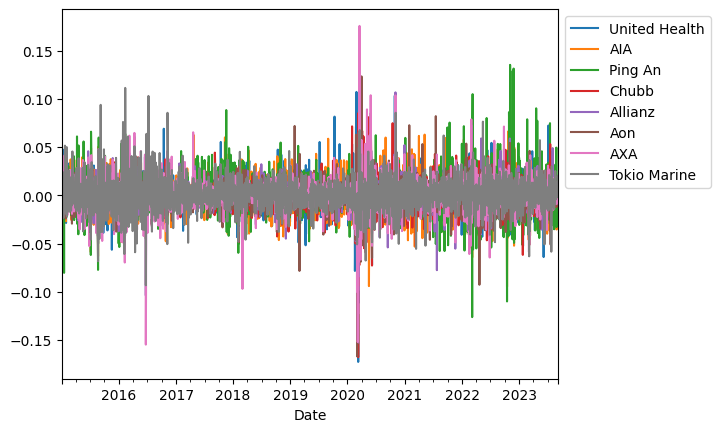

In [14]:
stock_returns.plot()
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

Let's just focus on one company. I choose Chubb.

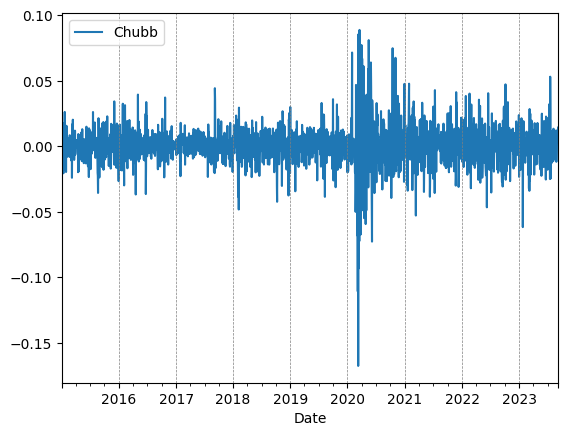

In [15]:
stock_returns[["Chubb"]].plot()
year_marks = [f"{year}-01-01" for year in range(2016, 2024)]
for mark in year_marks:
    plt.axvline(pd.to_datetime(mark), color='gray', linestyle='--', linewidth=0.5)

In [16]:
chubb_returns = stock_returns["Chubb"]
len(chubb_returns)

2264

The series consists of 2,264 daily returns. We split them into a five year training sample and a three year test sample. The gap in between is because the effects of the pandemic were thought to be non-representative of both the past and the future.

In [17]:
train = chubb_returns.loc["2015-01-05":"2019-12-31"]
test = chubb_returns.loc["2020-06-01":"2023-05-31"]

# Fit an Autoregressive Model

In [18]:
#from statsmodels.tsa.ar_model import AutoReg
#import matplotlib.pyplot as plt

# Fit AR(5) model on Chubb returns
model = AutoReg(train, lags=5, old_names=False)
model_fit = model.fit()
print(model_fit.summary())


                            AutoReg Model Results                             
Dep. Variable:                  Chubb   No. Observations:                 1302
Model:                     AutoReg(5)   Log Likelihood                4130.662
Method:               Conditional MLE   S.D. of innovations              0.010
Date:                Wed, 23 Jul 2025   AIC                          -8247.324
Time:                        15:32:22   BIC                          -8211.149
Sample:                    01-12-2015   HQIC                         -8233.749
                         - 12-31-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.766      0.077   -5.42e-05       0.001
Chubb.L1      -0.0461      0.028     -1.665      0.096      -0.100       0.008
Chubb.L2      -0.0365      0.028     -1.322      0.1

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


In [19]:
# Step 5: Forecast on test period
n_test = len(test)
pred = model_fit.predict(start=test.index[0], end=test.index[-1]);

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


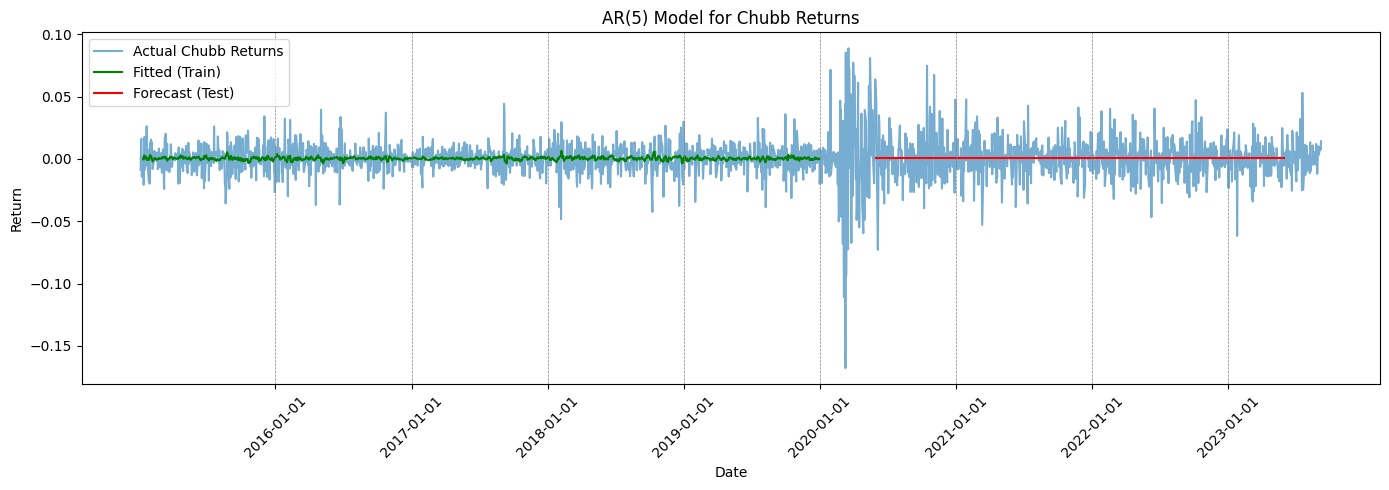

In [20]:

# Step 6: Plot actual and predicted Chubb returns
plt.figure(figsize=(14, 5))

# Plot full actual series
plt.plot(stock_returns["Chubb"], label="Actual Chubb Returns", alpha=0.6)

# Overlay fitted values in training
plt.plot(model_fit.fittedvalues, label="Fitted (Train)", color="green")

# Overlay predictions on test period
plt.plot(pred, label="Forecast (Test)", color="red")

# Step 7: Add year markers
year_marks = [f"{year}-01-01" for year in range(2016, 2024)]
for mark in year_marks:
    plt.axvline(pd.to_datetime(mark), color='gray', linestyle='--', linewidth=0.5)

# Step 8: Formatting
plt.title("AR(5) Model for Chubb Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.xticks(pd.to_datetime(year_marks), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Note that the predictions are essentially constant for this stationary model.

In [21]:
actual = test
pred = model_fit.predict(start=test.index[0], end=test.index[-1]);

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [22]:
#from sklearn.metrics import mean_squared_error as mse

rmse_val = mse(actual, pred)  ** 0.5

print(f"Test RMSE: {rmse_val:.6f}")


Test RMSE: 0.015417


# Fit a Recurrent Neural Network


## A Simple Recurrent Neural Net


Prepare supervised learning data (lagged matrix)

In [23]:
def create_lagged_data(series, lag=5):
    X, y = [], []
    for i in range(len(series) - lag):
        X.append(series[i:i+lag])
        y.append(series[i+lag])
    return np.array(X), np.array(y)


Extract and split Chubb returns

In [24]:
# Make sure 'stocks' is indexed by Date
chubb = stock_returns["Chubb"]

# Use only training + test period
full_series = chubb.loc["2015-01-05":"2023-05-31"]

# Create lagged data
lag = 5
X_all, y_all = create_lagged_data(full_series.values, lag=lag)

# Recreate date index for y (since we lose first `lag` dates)
date_y = full_series.index[lag:]

# Build DataFrame to index by date
X_df = pd.DataFrame(X_all, index=date_y)
y_df = pd.Series(y_all, index=date_y)

# Split train/test
X_train = X_df.loc["2015-01-05":"2019-12-31"].values
y_train = y_df.loc["2015-01-05":"2019-12-31"].values
X_test = X_df.loc["2020-06-01":"2023-05-31"].values
y_test = y_df.loc["2020-06-01":"2023-05-31"].values


Scale the data

In [25]:
#from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape to [samples, timesteps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], lag, 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], lag, 1))


Build and fit a simple RNN

In [26]:
#from keras.models import Sequential
#from keras.layers import SimpleRNN, Dense

random.seed(2025)

model = Sequential()
model.add(SimpleRNN(units=8, input_shape=(lag, 1), activation='tanh'))
model.add(Dense(1))  # output layer

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 8)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89 (356.00 B)

 Trainable params: 89 (356.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
%%time
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test_scaled, y_test), verbose=0)

CPU times: user 14 s, sys: 624 ms, total: 14.6 s
Wall time: 15.3 s


Evaluate predictions

In [28]:
y_pred = model.predict(X_test_scaled).flatten()

rmse = mse(y_test, y_pred)   ** 0.5

print(f"RNN Test RMSE: {rmse:.6f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RNN Test RMSE: 0.018137


A little better than the autoregressive model (but not by much)...

## Long Short-Term Model

Now, extend the model to include an LSTM layer.

In [29]:
#from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
random.seed(2025)
model = Sequential()
model.add(SimpleRNN(units=8, input_shape=(lag, 1), activation='tanh', return_sequences=True))
model.add(LSTM(units=8, activation='tanh'))  # No return_sequences because it's the last RNN
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 5, 8)           │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 633 (2.47 KB)

 Trainable params: 633 (2.47 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
%%time
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test_scaled, y_test), verbose=0)

CPU times: user 23.5 s, sys: 1.02 s, total: 24.5 s
Wall time: 23.7 s


In [31]:
y_pred = model.predict(X_test_scaled).flatten()

rmse = mse(y_test, y_pred)   ** 0.5

print(f"RNN with LSTM Test RMSE: {rmse:.6f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
RNN with LSTM Test RMSE: 0.015598


## Gated Recurrence Unit Layer

In [32]:
## from tensorflow.keras.layers import GRU, Dense
random.seed(2025)

model = Sequential()
model.add(GRU(units=16, input_shape=(lag, 1), return_sequences=True))
model.add(GRU(units=8))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 5, 16)          │           912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 8)              │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,545 (6.04 KB)

 Trainable params: 1,545 (6.04 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
%%time
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test_scaled, y_test), verbose=0)

CPU times: user 30.5 s, sys: 1.23 s, total: 31.7 s
Wall time: 31.8 s


In [34]:
y_pred = model.predict(X_test_scaled).flatten()

rmse = mse(y_test, y_pred)   ** 0.5

print(f"RNN with GRU Layers Test RMSE: {rmse:.6f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RNN with GRU Layers Test RMSE: 0.016249
